Found 2630 files belonging to 2 classes.
Found 563 files belonging to 2 classes.
Found 566 files belonging to 2 classes.


Model: "V20_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 8, 8, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,570 (6.00 MB)

 Trainable params: 1,571,586 (6.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7596 - loss: 0.9447
Epoch 1: val_loss improved from inf to 0.42235, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 478ms/step - accuracy: 0.7604 - loss: 0.9403 - val_accuracy: 0.8526 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8929 - loss: 0.3031
Epoch 2: val_loss did not improve from 0.42235
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.8929 - loss: 0.3030 - val_accuracy: 0.7798 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9069 - loss: 0.2621
Epoch 3: val_loss did not improve from 0.42235

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 475ms/step - accuracy: 0.9070 - loss: 0.2622 - val_accuracy: 0.6394 - val_loss: 0.8531 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy:

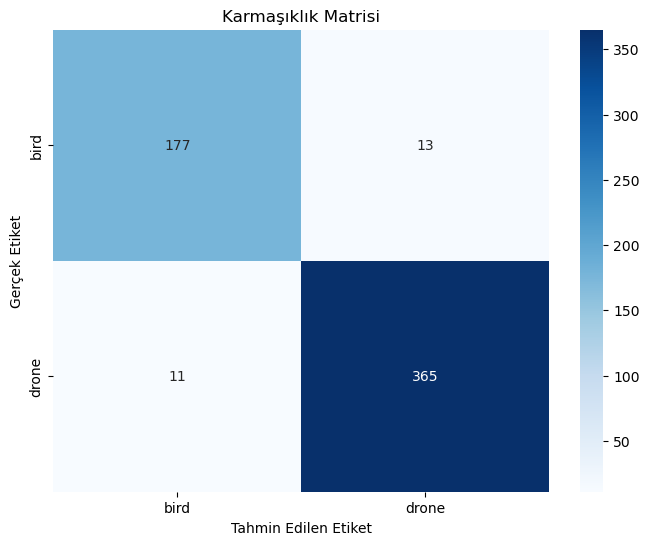

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BASE_PATH = "C:/Users/mkasl/Desktop/donem5/yap470/Ara_rapor_ 1/final_dataset1" 
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

IMAGE_SIZE = (128, 128) 
BATCH_SIZE = 32
tf.random.set_seed(42) #aynı sonucu vermesi için bunu gerçi dosyalara test train valid olarak ayırıyoruz
#tekrarlanabilirliği sağlıyor
EPOCHS = 30 
#%70 %15 %15 dağılım
#Veri setlerini yükleyip hazırlama categorical olması için one hot encoding yapıyorum
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=42)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)
class_names = train_dataset.class_names

#data augmentation yeni veriler üretip yapay olarak overfittingi önlemeye çalışıyorum
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

#Burası cache gibi önbellekleme vs. kullanıp performansı arttırmaya çalıştığım kısım ama buna rağmen daha farklı şeylere
#ihtiyacım var prefecthi sonraki batchi hazırlar cache önbelleğe alır
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential(name="V20_Model")
model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
#1. Blok
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#2. Blok
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#3. Blok
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#4. Blok
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="conv4"))
model.add(tf.keras.layers.BatchNormalization(name="bn4"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name="pool4"))
#5. Blok
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name="conv5"))
model.add(tf.keras.layers.BatchNormalization(name="bn5"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name="pool5"))
#GlobalAveragePooling2D ile sınıflandırma eskiden burasında flatten ve dense katmanı vardı
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.summary()

#Bu modelimde değiştirdiğim kısım
#Veri setindeki dosya sayılarını buluyorum ardından sınıfları sayıya göre ağırlıklandırıyorum
num_birds = len(os.listdir(os.path.join(TRAIN_PATH, 'bird'))) #sayma
num_drones = len(os.listdir(os.path.join(TRAIN_PATH, 'drone'))) #sayma
total_train_samples = num_birds + num_drones
#Ağırlıkları hesaplama
weight_for_bird = (1 / num_birds) * (total_train_samples / 2.0)
weight_for_drone = (1 / num_drones) * (total_train_samples / 2.0)
class_weights = {class_names.index('bird'): weight_for_bird, class_names.index('drone'): weight_for_drone}
#default olan adam optimizer kullanıyorum
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#EarlyStopping, Checkpoint ve Dinamik öğrenme callbackleri v10 modelimden dinamik öğrenme
callbacks = [
    # patience=5 olarak güncelledim öğrenme oranına ve sınıflandırmaya adapte olması için
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001)
]
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS,
  callbacks=callbacks,
  class_weight=class_weights
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
actual_epochs = len(acc) 
epochs_range = range(actual_epochs) #X eksenini dinamik olarak ayarlıyorum.
test_loss, test_accuracy = model.evaluate(test_dataset) #accuracy hesaplama 
print(f"\nTest Seti Doğruluğu: {test_accuracy:.4f}")
print(f"Test Seti Kaybı: {test_loss:.4f}")
# Karmaşıklık matrisi
y_true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true_labels, axis=1)
#Test setindeki tüm resimler için tahminleri al
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()